In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import spectral
from scipy import sparse
import scipy.sparse.linalg as spla

Let's try to solve viscous Burgers' equation:
$$ \partial_t u - \nu \partial_x^2 u = -u \partial_x u $$

What happens if we change the spatial resolution?

In [2]:
u_list = []
kx_list = []

In [3]:
x_basis = spectral.Fourier(128)
domain = spectral.Domain([x_basis])
dtype = np.complex128
u = spectral.Field(domain, dtype=dtype)
dudx = spectral.Field(domain, dtype=dtype)
RHS = spectral.Field(domain, dtype=dtype)

x = x_basis.grid()
u.require_grid_space()
u.data = 0.5*(np.sin(x)+1)

N = x_basis.N
kx = x_basis.wavenumbers()

nu = 1e-2
dt = 1e-2
t_end = 5
num_steps = int(t_end/dt)

In [4]:
kx

array([ 0.,  0.,  1.,  1.,  2.,  2.,  3.,  3.,  4.,  4.,  5.,  5.,  6.,
        6.,  7.,  7.,  8.,  8.,  9.,  9., 10., 10., 11., 11., 12., 12.,
       13., 13., 14., 14., 15., 15., 16., 16., 17., 17., 18., 18., 19.,
       19., 20., 20., 21., 21., 22., 22., 23., 23., 24., 24., 25., 25.,
       26., 26., 27., 27., 28., 28., 29., 29., 30., 30., 31., 31., 32.,
       32., 33., 33., 34., 34., 35., 35., 36., 36., 37., 37., 38., 38.,
       39., 39., 40., 40., 41., 41., 42., 42., 43., 43., 44., 44., 45.,
       45., 46., 46., 47., 47., 48., 48., 49., 49., 50., 50., 51., 51.,
       52., 52., 53., 53., 54., 54., 55., 55., 56., 56., 57., 57., 58.,
       58., 59., 59., 60., 60., 61., 61., 62., 62., 63., 63.])

<IPython.core.display.Javascript object>


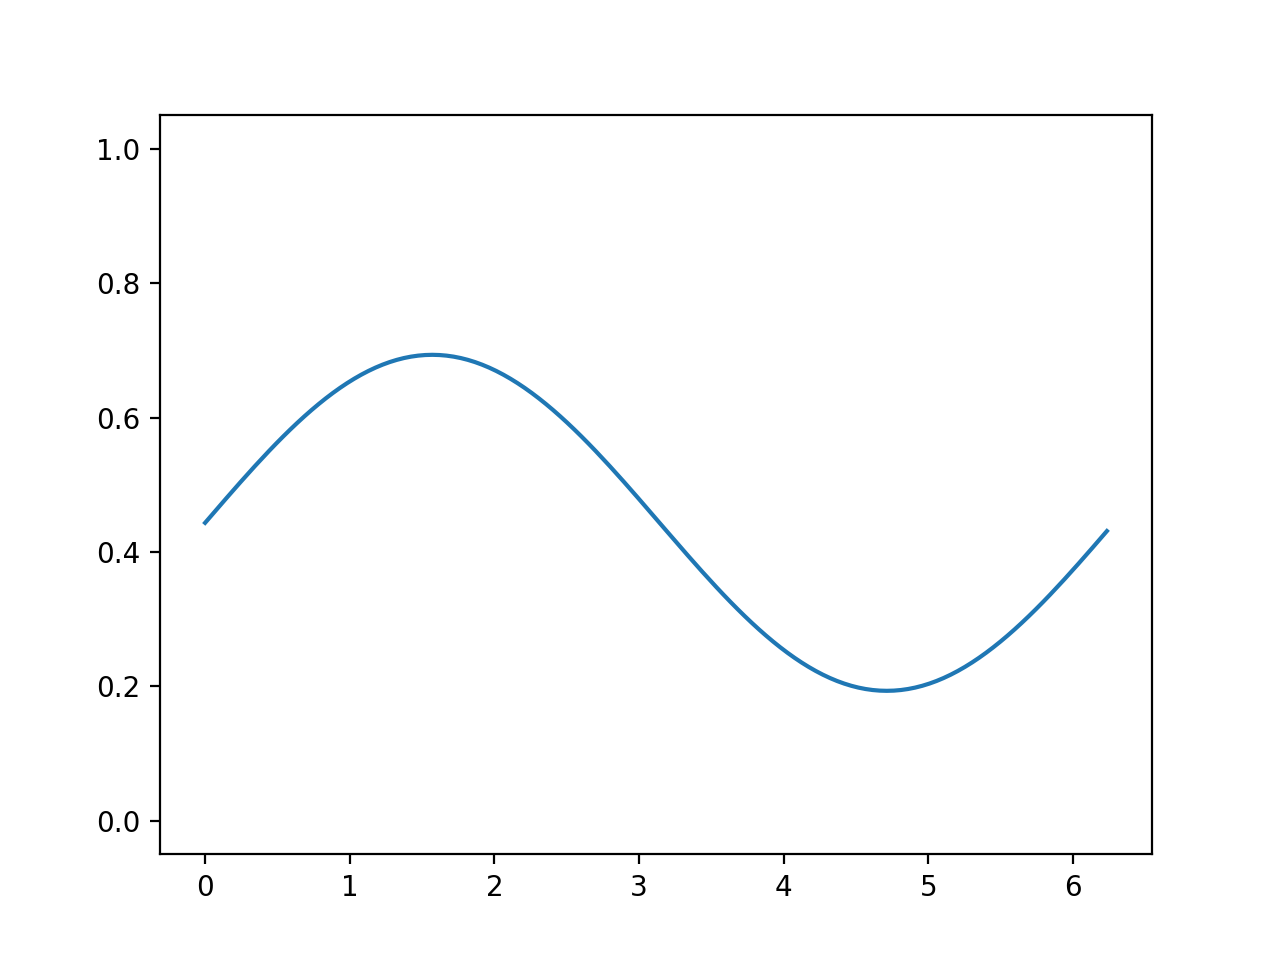

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [5]:
fig = plt.figure()
u.require_grid_space()
p, = plt.plot(x, u.data)
fig.canvas.draw()

for i in range(num_steps):
    # take a timestep:
    u.require_coeff_space()
    dudx.require_coeff_space()
    dudx.data = 1j*kx*u.data
    u.require_grid_space(scales=2)
    dudx.require_grid_space(scales=2)
    RHS.require_grid_space(scales=2)
    RHS.data = -u.data * dudx.data
    RHS.require_coeff_space()

    diag = 1/dt + nu*kx**2
    LHS = sparse.diags(diag)
    u.require_coeff_space()
    RHS.data += u.data/dt
    u.data = spla.spsolve(LHS, RHS.data)
    
    if i % 5 == 0:
        u.require_grid_space()
        p.set_ydata(u.data.real)
        fig.canvas.draw()

In [6]:
u.require_coeff_space()
u_list.append(u.data)
kx_list.append(x_basis.wavenumbers(dtype))

<IPython.core.display.Javascript object>


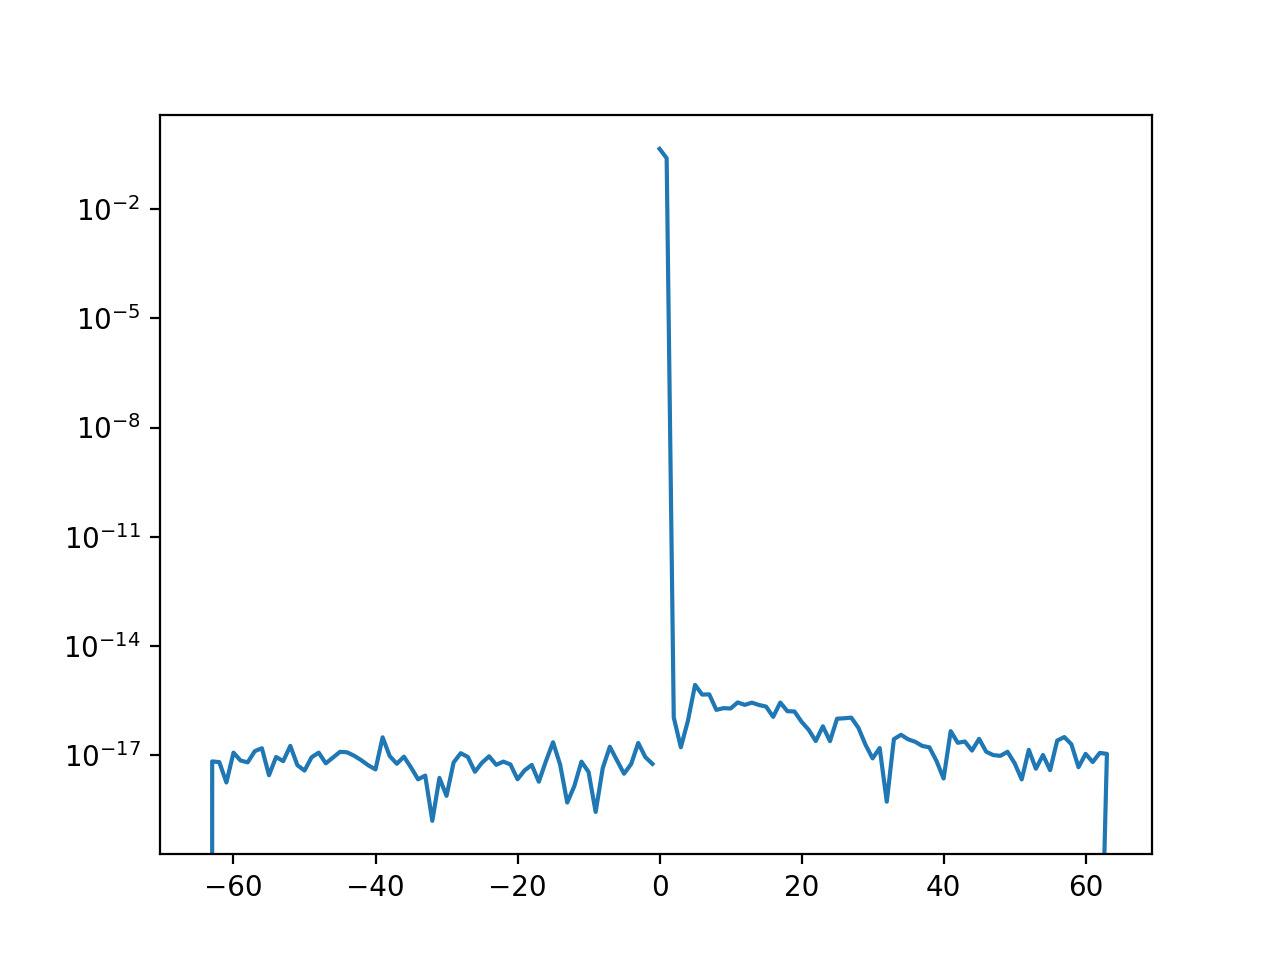

In [7]:
plt.figure()
for u, kx in zip(u_list, kx_list):
    plt.plot(kx, np.abs(u))
plt.yscale('log')

How do we do this using the `spectral.py` framework?

In [10]:
x_basis = spectral.Fourier(128)
domain = spectral.Domain([x_basis])
dtype = np.complex128
u = spectral.Field(domain, dtype=dtype)
dudx = spectral.Field(domain, dtype=dtype)
RHS = spectral.Field(domain, dtype=dtype) # -u*dudx
problem = spectral.InitialValueProblem(domain, [u], [RHS], dtype=dtype)

x = x_basis.grid()
u.require_grid_space()
u.data = 0.5*(np.sin(x)+1)

nu = 1e-2
dt = 1e-2
t_end = 5
num_steps = int(t_end/dt)

# need to specify L and M matrix
p = problem.pencils[0]

I = sparse.eye(x_basis.N, dtype=dtype)
p.M = I
diag = nu*x_basis.wavenumbers(dtype)**2
p.L = sparse.diags(diag)


In [11]:
ts = spectral.SBDF2(problem)

for i in range(num_steps):
    # need to calculate -u*ux and put it into RHS
    u.require_coeff_space()
    dudx.require_coeff_space()
    dudx.data = 1j*kx*u.data
    u.require_grid_space(scales=3/2)
    dudx.require_grid_space(scales=3/2)
    RHS.require_grid_space(scales=3/2)
    RHS.data = -u.data * dudx.data
    
    # take timestep
    ts.step(dt)

<IPython.core.display.Javascript object>


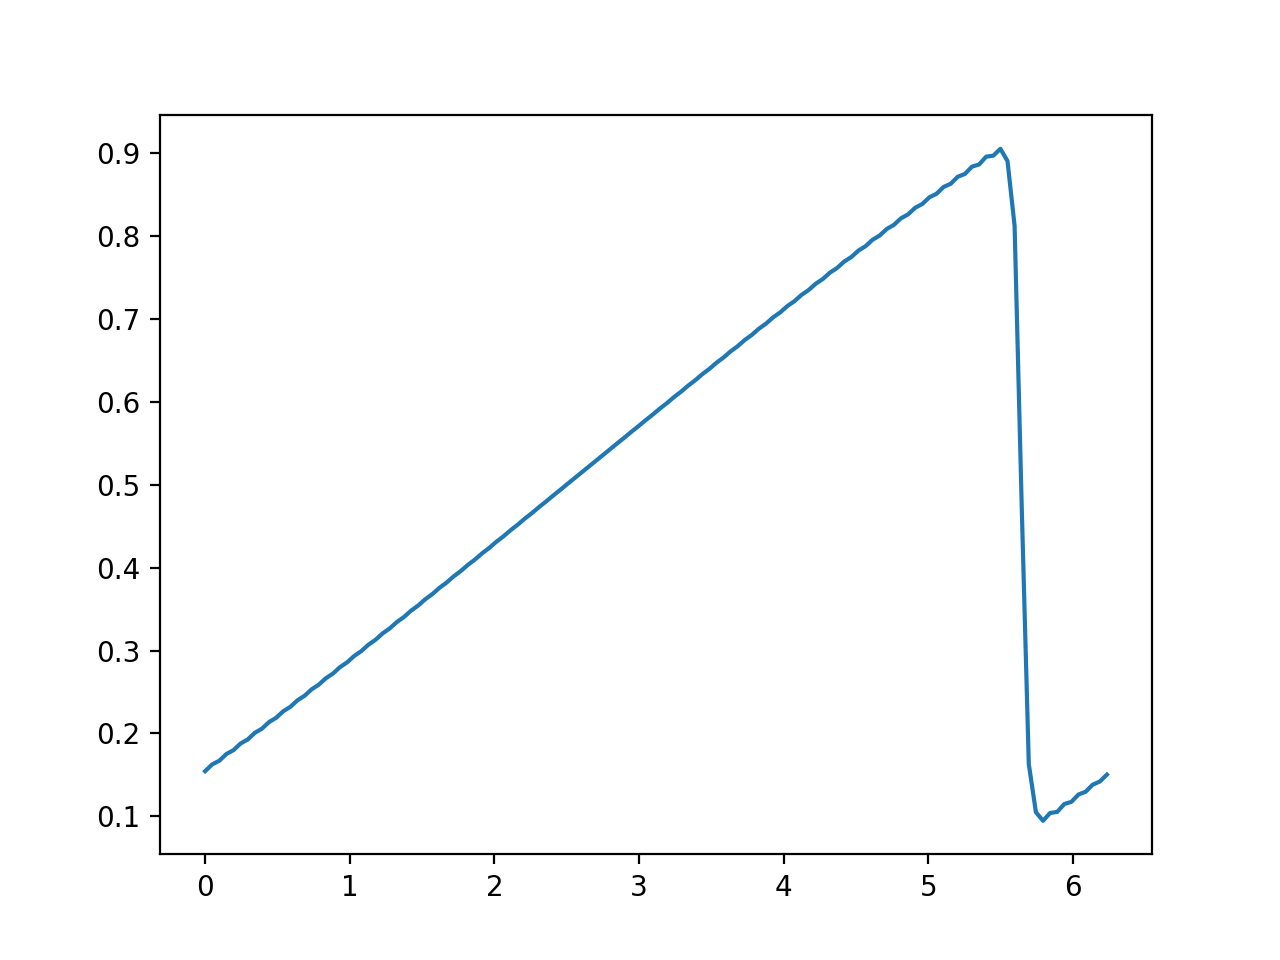

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [12]:
plt.figure()
u.require_grid_space()
plt.plot(x, u.data)

<IPython.core.display.Javascript object>


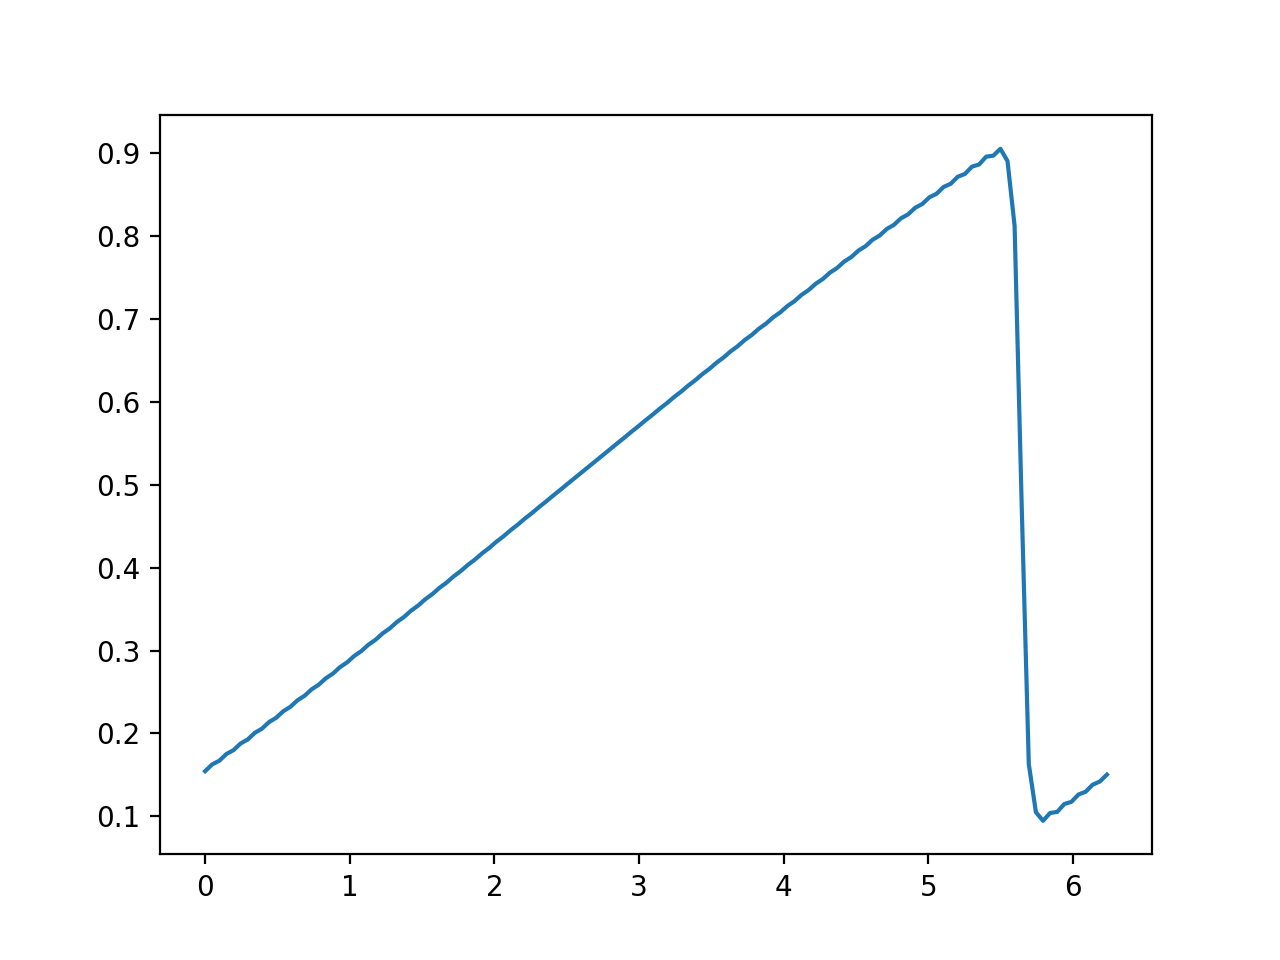

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [13]:
u.require_grid_space()
plt.figure()
plt.plot(x, u.data)

Now let's make a class for Viscous Burgers' equation to wrap this all up.

In [10]:
class BurgersEquation:
    
    def __init__(self, domain, u, nu):
        # store data we need for later, make M and L matrices
        self.dtype = u.dtype
        dtype = self.dtype
        self.u = u
        self.domain = domain
        self.dudx = spectral.Field(domain, dtype=dtype)
        self.RHS = spectral.Field(domain, dtype=dtype) # -u*dudx
        self.problem = spectral.InitialValueProblem(domain, [self.u], [self.RHS], dtype=dtype)

        p = self.problem.pencils[0]
        
        x_basis = domain.bases[0]
        
        if dtype == np.complex128:
            I = sparse.eye(x_basis.N, dtype=dtype)
            p.M = I
            diag = nu*x_basis.wavenumbers(dtype=dtype)**2
            p.L = sparse.diags(diag, dtype=dtype)
        else:
            I = sparse.eye(x_basis.N, dtype=dtype)
            p.M = I
            diag = -nu*x_basis.wavenumbers(dtype=dtype)**2
            p.L = sparse.diags(diag, dtype=dtype)
        
#         print(p.M)
#         print(p.L)
        
    def evolve(self, timestepper, dt, num_steps): # take timesteps
        ts = timestepper(self.problem)
        x_basis = self.domain.bases[0]
        u = self.u
        dudx = self.dudx
        RHS = self.RHS
        n = np.zeros(len(x_basis.wavenumbers(self.dtype)))
        n[::2] = -x_basis.wavenumbers(self.dtype)[1::2]
        n[1::2] = x_basis.wavenumbers(self.dtype)[::2]

        for i in range(num_steps):
            # need to calculate -u*ux and put it into RHS
            u.require_coeff_space()
            dudx.require_coeff_space()
            if self.dtype == np.complex128:
                dudx.data = 1j*x_basis.wavenumbers(self.dtype)*u.data
            else:
                dudx.data = n*u.data
            u.require_grid_space(scales=3/2)
            dudx.require_grid_space(scales=3/2)
            RHS.require_grid_space(scales=3/2)
            RHS.data = -u.data * dudx.data

            # take timestep
            ts.step(dt)

In [38]:
class KdVEquation:
    
    def __init__(self, domain, u):
        # store data we need for later, make M and L matrices
        self.dtype = u.dtype
        dtype = self.dtype
        self.u = u
        self.domain = domain
        self.dudx = spectral.Field(domain, dtype=dtype)
        self.RHS = spectral.Field(domain, dtype=dtype) # 6*u*dudx
        self.problem = spectral.InitialValueProblem(domain, [self.u], [self.RHS], dtype=dtype)

        p = self.problem.pencils[0]

        x_basis = domain.bases[0]
        I = sparse.eye(x_basis.N)
        p.M = I
        if dtype == np.complex128:
            diag = -1j*x_basis.wavenumbers(dtype)**3
            p.L = sparse.diags(diag)
        else:
            diag = x_basis.wavenumbers(dtype)**3
            d = np.zeros(len(diag))
            d[::2] = diag[1::2]
            d[1::2] = -diag[::2]
            print(d)
            p.L = sparse.diags(d, dtype=dtype)
        
    def evolve(self, timestepper, dt, num_steps): # take timesteps
        ts = timestepper(self.problem)
        x_basis = self.domain.bases[0]
        u = self.u
        dudx = self.dudx
        RHS = self.RHS

        for i in range(num_steps):
            # need to calculate -u*ux and put it into RHS
            u.require_coeff_space()
            dudx.require_coeff_space()
            if self.dtype == np.complex128:
                dudx.data = 1j*x_basis.wavenumbers(self.dtype)*u.data
            else:
                n = np.zeros(len(x_basis.wavenumbers(self.dtype)))
                n[::2] = -x_basis.wavenumbers(self.dtype)[1::2]
                n[1::2] = x_basis.wavenumbers(self.dtype)[::2]
                print(n)
                dudx.data = n*u.data
            u.require_grid_space(scales=3/2)
            dudx.require_grid_space(scales=3/2)
            RHS.require_grid_space(scales=3/2)
            RHS.data = 6 * u.data * dudx.data

            # take timestep
            ts.step(dt)

In [11]:
x_basis = spectral.Fourier(128)
domain = spectral.Domain([x_basis])
dtype = np.float64
u = spectral.Field(domain, dtype=dtype)
u.require_grid_space()
x = x_basis.grid()
# u.data = -2*np.exp(-0.5*(x-2*np.pi)**2)
u.data = 0.5*(np.sin(x)+1)

VB = BurgersEquation(domain, u, 1e-2)

In [39]:
dtype=np.float64
x_basis = spectral.Fourier(64, interval=(0, 4*np.pi))
domain = spectral.Domain([x_basis])
x = x_basis.grid()
u = spectral.Field(domain, dtype=dtype)
u.require_grid_space()
u.data = -2*np.cosh((x-2*np.pi))**(-2)

KdV = KdVEquation(domain, u)

[ 0.000000e+00 -0.000000e+00  1.250000e-01 -1.250000e-01  1.000000e+00
 -1.000000e+00  3.375000e+00 -3.375000e+00  8.000000e+00 -8.000000e+00
  1.562500e+01 -1.562500e+01  2.700000e+01 -2.700000e+01  4.287500e+01
 -4.287500e+01  6.400000e+01 -6.400000e+01  9.112500e+01 -9.112500e+01
  1.250000e+02 -1.250000e+02  1.663750e+02 -1.663750e+02  2.160000e+02
 -2.160000e+02  2.746250e+02 -2.746250e+02  3.430000e+02 -3.430000e+02
  4.218750e+02 -4.218750e+02  5.120000e+02 -5.120000e+02  6.141250e+02
 -6.141250e+02  7.290000e+02 -7.290000e+02  8.573750e+02 -8.573750e+02
  1.000000e+03 -1.000000e+03  1.157625e+03 -1.157625e+03  1.331000e+03
 -1.331000e+03  1.520875e+03 -1.520875e+03  1.728000e+03 -1.728000e+03
  1.953125e+03 -1.953125e+03  2.197000e+03 -2.197000e+03  2.460375e+03
 -2.460375e+03  2.744000e+03 -2.744000e+03  3.048625e+03 -3.048625e+03
  3.375000e+03 -3.375000e+03  3.723875e+03 -3.723875e+03]


<IPython.core.display.Javascript object>


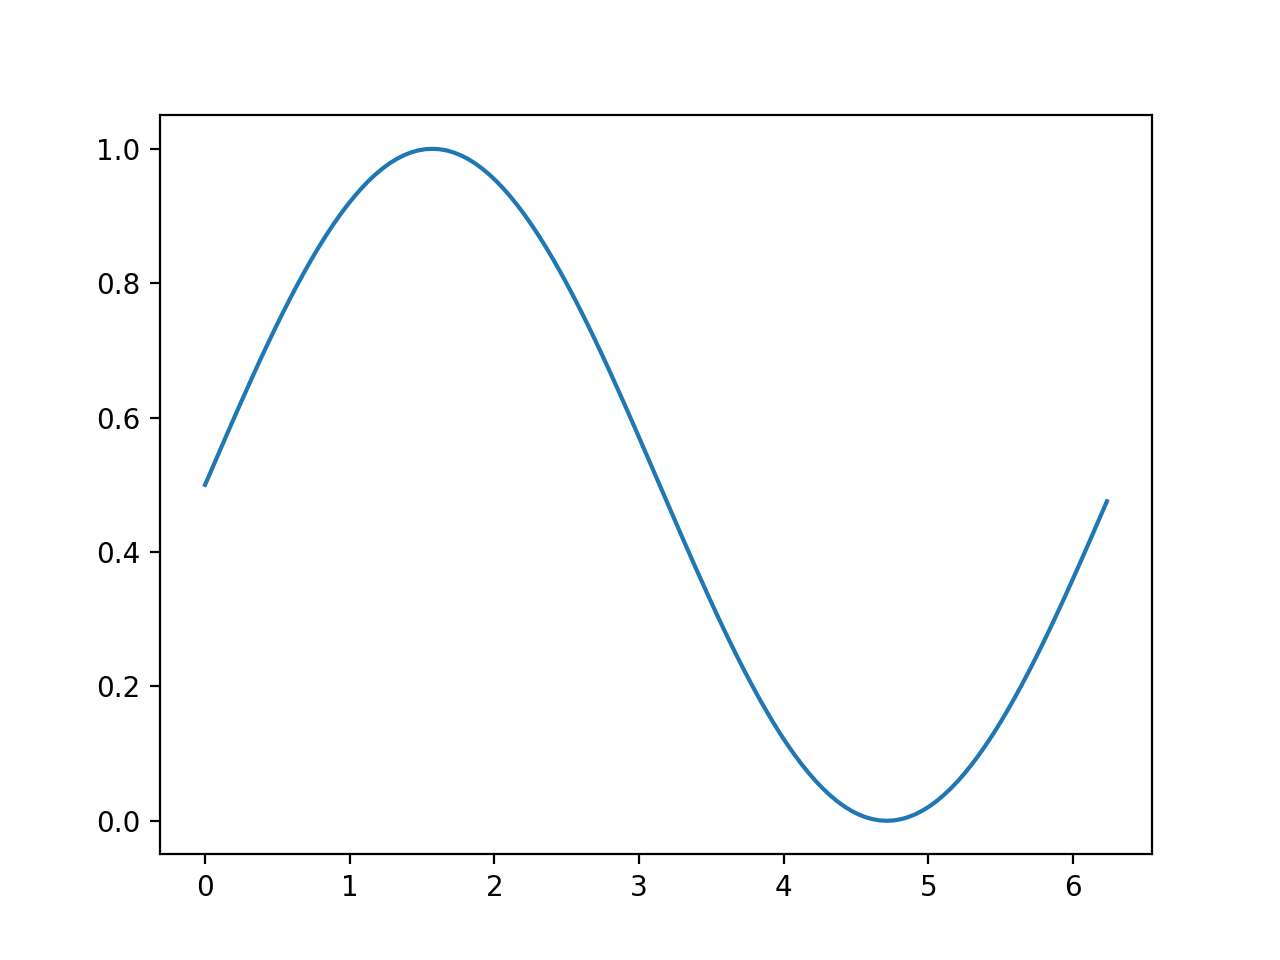

In [12]:
plt.figure()
u.require_grid_space()
plt.plot(x, u.data)

In [40]:
KdV.evolve(spectral.SBDF2, 1e-2, 500)

[ -0.    0.   -0.5   0.5  -1.    1.   -1.5   1.5  -2.    2.   -2.5   2.5
  -3.    3.   -3.5   3.5  -4.    4.   -4.5   4.5  -5.    5.   -5.5   5.5
  -6.    6.   -6.5   6.5  -7.    7.   -7.5   7.5  -8.    8.   -8.5   8.5
  -9.    9.   -9.5   9.5 -10.   10.  -10.5  10.5 -11.   11.  -11.5  11.5
 -12.   12.  -12.5  12.5 -13.   13.  -13.5  13.5 -14.   14.  -14.5  14.5
 -15.   15.  -15.5  15.5]
[ -0.    0.   -0.5   0.5  -1.    1.   -1.5   1.5  -2.    2.   -2.5   2.5
  -3.    3.   -3.5   3.5  -4.    4.   -4.5   4.5  -5.    5.   -5.5   5.5
  -6.    6.   -6.5   6.5  -7.    7.   -7.5   7.5  -8.    8.   -8.5   8.5
  -9.    9.   -9.5   9.5 -10.   10.  -10.5  10.5 -11.   11.  -11.5  11.5
 -12.   12.  -12.5  12.5 -13.   13.  -13.5  13.5 -14.   14.  -14.5  14.5
 -15.   15.  -15.5  15.5]
[ -0.    0.   -0.5   0.5  -1.    1.   -1.5   1.5  -2.    2.   -2.5   2.5
  -3.    3.   -3.5   3.5  -4.    4.   -4.5   4.5  -5.    5.   -5.5   5.5
  -6.    6.   -6.5   6.5  -7.    7.   -7.5   7.5  -8.    8.   -8.5   8.5

/var/folders/yl/n21qhxyn5093pv7cynvb2_7w0000gn/T/ipykernel_85599/394229220.py:51: RuntimeWarning: overflow encountered in multiply
  RHS.data = 6 * u.data * dudx.data


[ -0.    0.   -0.5   0.5  -1.    1.   -1.5   1.5  -2.    2.   -2.5   2.5
  -3.    3.   -3.5   3.5  -4.    4.   -4.5   4.5  -5.    5.   -5.5   5.5
  -6.    6.   -6.5   6.5  -7.    7.   -7.5   7.5  -8.    8.   -8.5   8.5
  -9.    9.   -9.5   9.5 -10.   10.  -10.5  10.5 -11.   11.  -11.5  11.5
 -12.   12.  -12.5  12.5 -13.   13.  -13.5  13.5 -14.   14.  -14.5  14.5
 -15.   15.  -15.5  15.5]
[ -0.    0.   -0.5   0.5  -1.    1.   -1.5   1.5  -2.    2.   -2.5   2.5
  -3.    3.   -3.5   3.5  -4.    4.   -4.5   4.5  -5.    5.   -5.5   5.5
  -6.    6.   -6.5   6.5  -7.    7.   -7.5   7.5  -8.    8.   -8.5   8.5
  -9.    9.   -9.5   9.5 -10.   10.  -10.5  10.5 -11.   11.  -11.5  11.5
 -12.   12.  -12.5  12.5 -13.   13.  -13.5  13.5 -14.   14.  -14.5  14.5
 -15.   15.  -15.5  15.5]
[ -0.    0.   -0.5   0.5  -1.    1.   -1.5   1.5  -2.    2.   -2.5   2.5
  -3.    3.   -3.5   3.5  -4.    4.   -4.5   4.5  -5.    5.   -5.5   5.5
  -6.    6.   -6.5   6.5  -7.    7.   -7.5   7.5  -8.    8.   -8.5   8.5

 -15.   15.  -15.5  15.5]
[ -0.    0.   -0.5   0.5  -1.    1.   -1.5   1.5  -2.    2.   -2.5   2.5
  -3.    3.   -3.5   3.5  -4.    4.   -4.5   4.5  -5.    5.   -5.5   5.5
  -6.    6.   -6.5   6.5  -7.    7.   -7.5   7.5  -8.    8.   -8.5   8.5
  -9.    9.   -9.5   9.5 -10.   10.  -10.5  10.5 -11.   11.  -11.5  11.5
 -12.   12.  -12.5  12.5 -13.   13.  -13.5  13.5 -14.   14.  -14.5  14.5
 -15.   15.  -15.5  15.5]
[ -0.    0.   -0.5   0.5  -1.    1.   -1.5   1.5  -2.    2.   -2.5   2.5
  -3.    3.   -3.5   3.5  -4.    4.   -4.5   4.5  -5.    5.   -5.5   5.5
  -6.    6.   -6.5   6.5  -7.    7.   -7.5   7.5  -8.    8.   -8.5   8.5
  -9.    9.   -9.5   9.5 -10.   10.  -10.5  10.5 -11.   11.  -11.5  11.5
 -12.   12.  -12.5  12.5 -13.   13.  -13.5  13.5 -14.   14.  -14.5  14.5
 -15.   15.  -15.5  15.5]
[ -0.    0.   -0.5   0.5  -1.    1.   -1.5   1.5  -2.    2.   -2.5   2.5
  -3.    3.   -3.5   3.5  -4.    4.   -4.5   4.5  -5.    5.   -5.5   5.5
  -6.    6.   -6.5   6.5  -7.    7.   -7.5   7

[ -0.    0.   -0.5   0.5  -1.    1.   -1.5   1.5  -2.    2.   -2.5   2.5
  -3.    3.   -3.5   3.5  -4.    4.   -4.5   4.5  -5.    5.   -5.5   5.5
  -6.    6.   -6.5   6.5  -7.    7.   -7.5   7.5  -8.    8.   -8.5   8.5
  -9.    9.   -9.5   9.5 -10.   10.  -10.5  10.5 -11.   11.  -11.5  11.5
 -12.   12.  -12.5  12.5 -13.   13.  -13.5  13.5 -14.   14.  -14.5  14.5
 -15.   15.  -15.5  15.5]
[ -0.    0.   -0.5   0.5  -1.    1.   -1.5   1.5  -2.    2.   -2.5   2.5
  -3.    3.   -3.5   3.5  -4.    4.   -4.5   4.5  -5.    5.   -5.5   5.5
  -6.    6.   -6.5   6.5  -7.    7.   -7.5   7.5  -8.    8.   -8.5   8.5
  -9.    9.   -9.5   9.5 -10.   10.  -10.5  10.5 -11.   11.  -11.5  11.5
 -12.   12.  -12.5  12.5 -13.   13.  -13.5  13.5 -14.   14.  -14.5  14.5
 -15.   15.  -15.5  15.5]
[ -0.    0.   -0.5   0.5  -1.    1.   -1.5   1.5  -2.    2.   -2.5   2.5
  -3.    3.   -3.5   3.5  -4.    4.   -4.5   4.5  -5.    5.   -5.5   5.5
  -6.    6.   -6.5   6.5  -7.    7.   -7.5   7.5  -8.    8.   -8.5   8.5

In [13]:
VB.evolve(spectral.SBDF2, 1e-2, 500)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/var/folders/yl/n21qhxyn5093pv7cynvb2_7w0000gn/T/ipykernel_85861/13039005.py:58: RuntimeWarning: overflow encountered in multiply
  RHS.data = -u.data * dudx.data


<IPython.core.display.Javascript object>


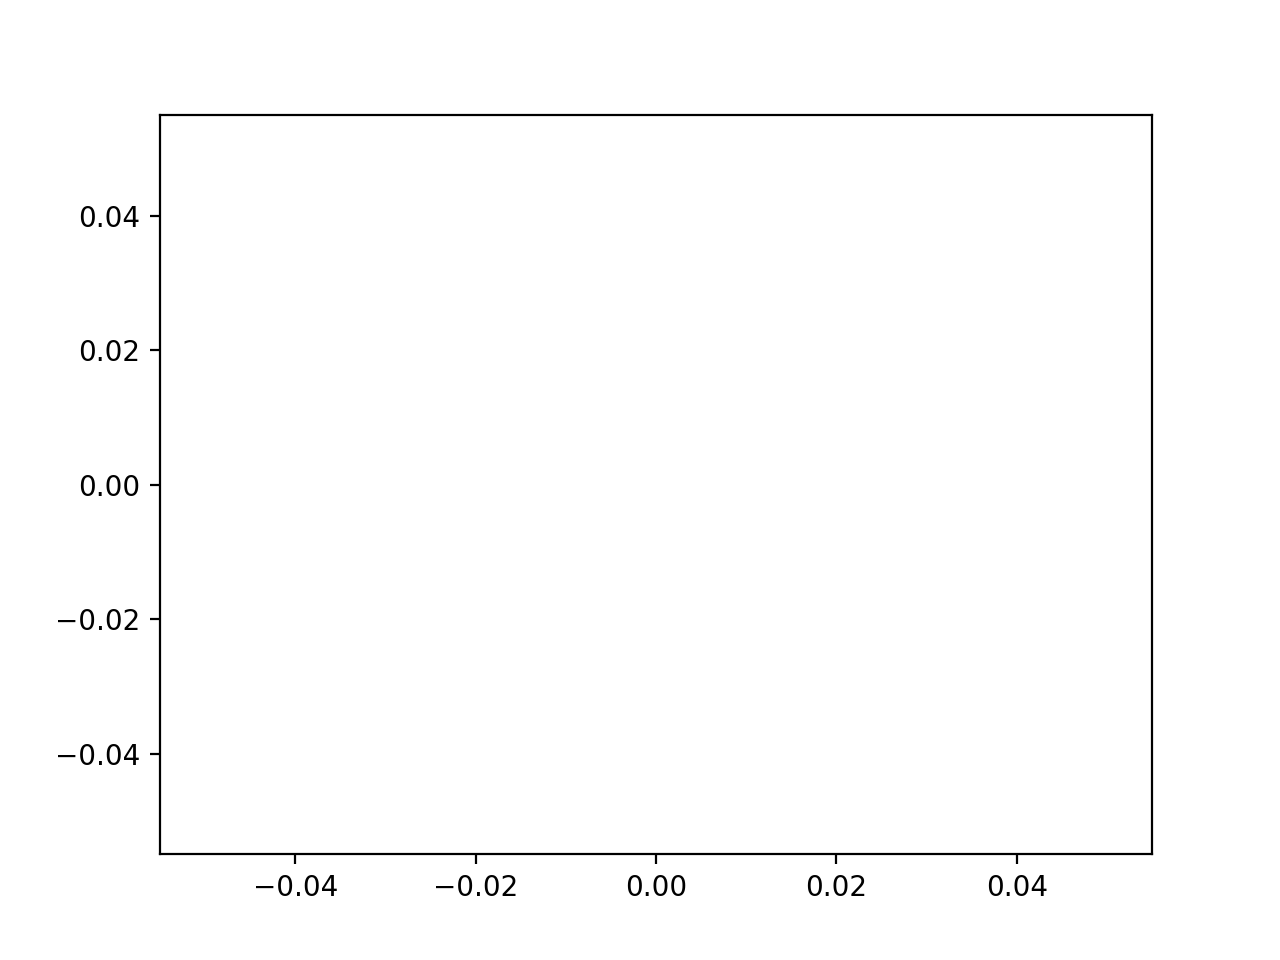

In [52]:
plt.figure()
u.require_grid_space()
plt.plot(x, u.data)

In [46]:
u.data

array([0.5       , 0.52333731, 0.54661839, 0.56978717, 0.59278783,
       0.61556495, 0.63806366, 0.66022977, 0.68200987, 0.70335149,
       0.72420322, 0.74451483, 0.76423738, 0.78332336, 0.80172678,
       0.81940332, 0.83631039, 0.85240726, 0.86765515, 0.88201732,
       0.89545918, 0.90794835, 0.91945473, 0.92995061, 0.9394107 ,
       0.94781221, 0.95513491, 0.96136114, 0.96647591, 0.9704669 ,
       0.9733245 , 0.97504182, 0.97561472, 0.97504182, 0.9733245 ,
       0.9704669 , 0.96647591, 0.96136114, 0.95513491, 0.94781221,
       0.9394107 , 0.92995061, 0.91945473, 0.90794835, 0.89545918,
       0.88201732, 0.86765515, 0.85240726, 0.83631039, 0.81940332,
       0.80172678, 0.78332336, 0.76423738, 0.74451483, 0.72420322,
       0.70335149, 0.68200987, 0.66022977, 0.63806366, 0.61556495,
       0.59278783, 0.56978717, 0.54661839, 0.52333731, 0.5       ,
       0.47666269, 0.45338161, 0.43021283, 0.40721217, 0.38443505,
       0.36193634, 0.33977023, 0.31799013, 0.29664851, 0.27579